In [45]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 16 14:01:03 2024

@author: hssdwo
"""
import sys, os
sys.path.append(os.path.join(sys.path[0], '..'))

import os
import imageio.v3 as iio
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import cv2
from skimage.morphology import closing
from scipy.stats import mode
from sklearn.neighbors import KernelDensity

from image_cleaning import get_rotation_angle
# For automatic digitisation tools to work, we need to clean up the initial image in stages:
# 1. rotate image (note that this can be applied to image, or to the extracted signal at the end)
# 2. de-shadow image
# 3. identify the 12 lead labels, and segment the image into the 12 leads

In [3]:
def std_rescale(image, contrast=1):
    """
    Standardizes to between [-contrast, contrast] regardless of range of input
    """
    ptp_ratio = contrast/np.ptp(image)
    shift = (np.max(image) + np.min(image))/contrast # works with negative values
    return ptp_ratio*(image - shift)

def norm_rescale(image, contrast=1):
    """
    Normalizes to zero mean and scales to have one of (abs(max), abs(min)) = contrast
    """
    scale = np.max(np.abs([np.max(image), np.min(image)]))
    return contrast*(image - np.mean(image))/scale

def zero_one_rescale(image):
    """
    Rescales to between 0 and 1
    """
    return (image - np.min(image))/np.ptp(image)

def sigmoid(x):
    """
    tanh sigmoid function
    """
    return 1./(1. + np.exp(-x))
    

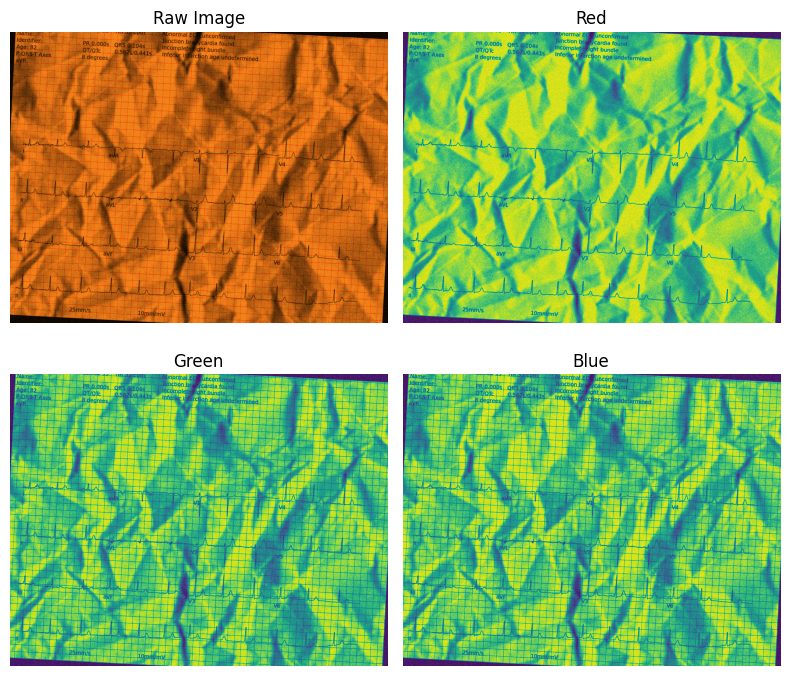

In [66]:
# ---- import image from folder ------
# im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00001_hr-0.png'))
# im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00003_hr-0.png'))
im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00021_hr-0.png'))
# im = iio.imread('D:\\Downloads\\test.png') # 500hz_00000_sample/00099_hr-0.png


# files are png, in RGBa format. The alpha channel is 255 for all pixels (opaque) and therefore
# totally uniformative. Let's remove it
im = np.delete(im, np.s_[-1:], axis=2)

# plot to view the raw image, and the RGB channels individually
# by default is uint8, convert to float to avoid overflow
red_im = im[:,:,0].astype(np.float32)
green_im = im[:,:,1].astype(np.float32)
blue_im =  im[:,:,2].astype(np.float32)

fig, axs = plt.subplots(2,2)
# remove tickers from axes
for ax in axs.flatten():
    ax.axis('off')
# set figure size 
fig.set_size_inches(8, 7)
# tight layout
plt.tight_layout()
axs[0,0].title.set_text('Raw Image')
axs[0,0].imshow(im)
axs[0,1].title.set_text('Red')
axs[0,1].imshow(red_im)
axs[1,0].title.set_text('Green')
axs[1,0].imshow(green_im) 
axs[1,1].title.set_text('Blue')
axs[1,1].imshow(blue_im)
plt.show()


In [67]:
# get rotation angle
rot_angle = get_rotation_angle(blue_im, red_im)

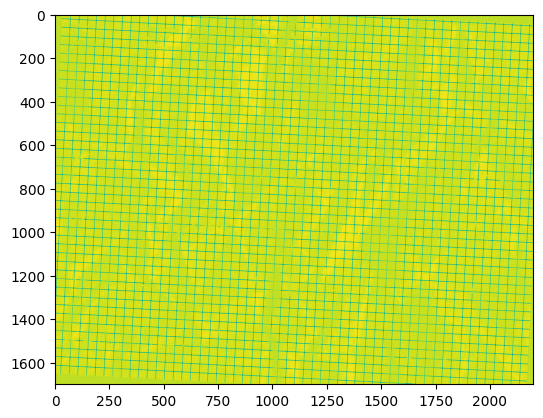

In [68]:
## ---- process the image to enhance the grid and get rid of shadows
# this seems to work because the grid lines are usually not visible in red channel - SS
# todo - fix magic number here
scale = np.mean(blue_im)/np.mean(red_im)
dev_im = blue_im - (red_im*scale) # scaled red image so that it is the same brightness. Hard_coded for now
plt.figure()
plt.imshow(dev_im)


In [65]:
grid = blue_im - (red_im*scale) # save this for later

# grid = grid - np.min(grid)
# this is crazy sensitive, wild really
# grid_mode_adjusted = sp.stats.mode(grid, axis=None)[0] - 10
# grid[grid<grid_mode_adjusted] = 0
# grid[grid>grid_mode_adjusted] = 255
grid_filter = sigmoid(std_rescale(-grid))
plt.figure()
plt.imshow(grid_filter)

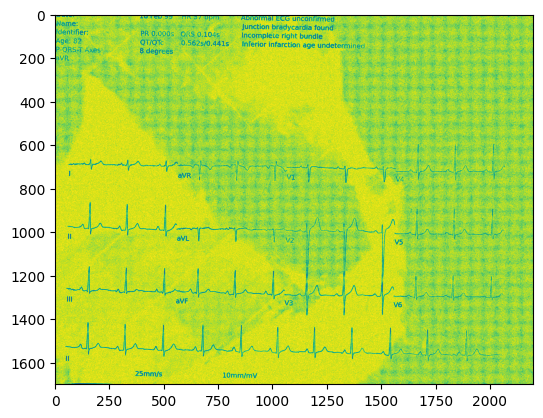

In [7]:
# morphological filter on red channel? (closing?)
test = closing(red_im, footprint=[(np.ones((7, 1)), 1), (np.ones((1, 7)), 1)])

output_im = red_im - test
plt.figure()
plt.imshow(output_im)

no pixels below threshold


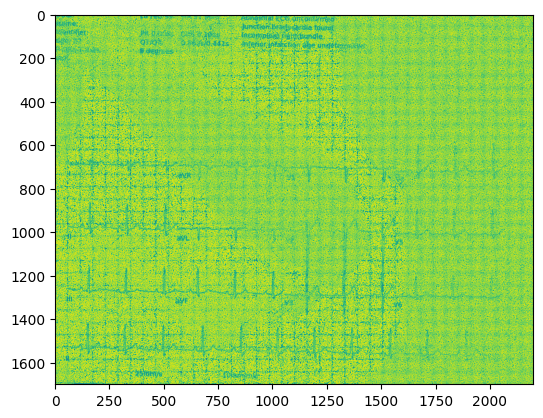

In [8]:
# darken the 9.2% darkest pixels
# THIS ONLY WORKS FOR 8 BIT UNSIGNED INTS BTW
output_im_8bit = output_im.copy().astype(np.uint8)
vals = output_im_8bit.flatten()
b = np.histogram(vals,255) # puts into bins of pixel values
a = np.cumsum(b[0]) # cumulative sum of number of pixels ? like a gradient
c = a[-1]*0.092 # find smallest 9.2% 
# thresh = np.argmax(a[a<345260])
if a[0] > c:
    print('no pixels below threshold')
    thresh = 255*0.092
else:
    thresh = np.argmax(a[a<c])

output_im_8bit[output_im_8bit<thresh] = 0 # need to figure out this magic number
plt.figure()
plt.imshow(output_im_8bit)

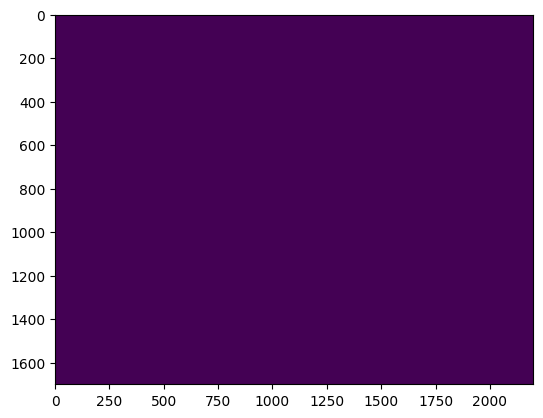

In [9]:
# showing that it breaks completely if dtype is float32
output_im_float = output_im.copy().astype(np.float32)
vals = output_im_float.flatten()
b = np.histogram(vals,255) # puts into bins of pixel values
a = np.cumsum(b[0]) # cumulative sum of number of pixels ? like a gradient
c = a[-1]*0.092 # find smallest 9.2% 
# thresh = np.argmax(a[a<345260])
if a[0] > c:
    print('no pixels below threshold')
    thresh = 255*0.092
else:
    thresh = np.argmax(a[a<c])

output_im_float[output_im_float<thresh] = 0 # need to figure out this magic number
plt.figure()
plt.imshow(output_im_float)

0.0
-174.0


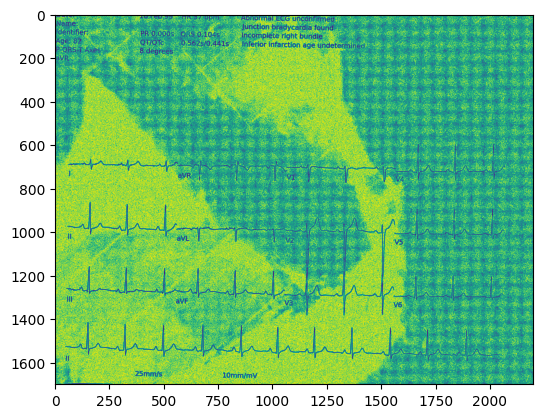

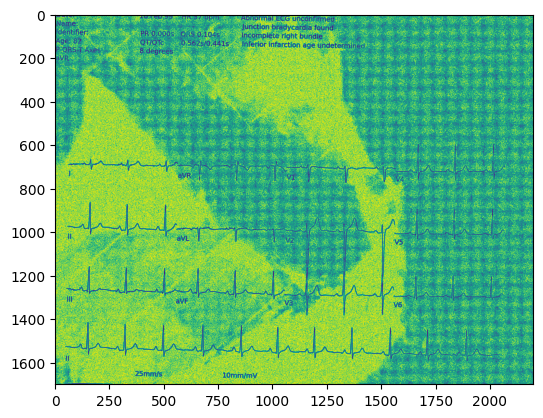

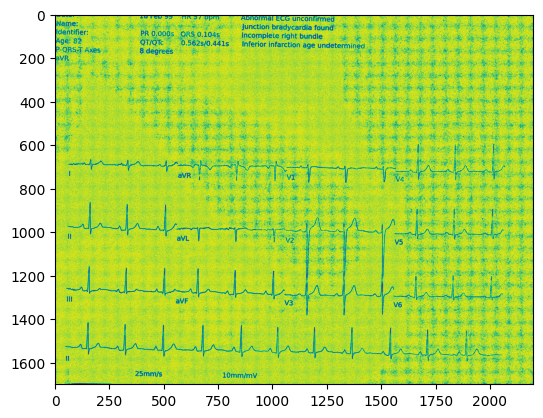

In [59]:
# Alternately, try applying a sigmoid to the image

# normalize to have 0 mean and values between -1 and 1
# contrast is a magic number here, tanh caps out around -4ish
print(output_im.max())
print(output_im.min())
sigmoid_norm = 255*sigmoid(norm_rescale(output_im, contrast=8))
sigmoid_std = 255*sigmoid(std_rescale(output_im, contrast=8))

# feel like we can combine these somehow to be useful?

dev_im = blue_im - (red_im*scale) 
combo = sigmoid_norm - sigmoid_std
scale = np.mean(combo)/np.mean(grid_filter)
combo2 = combo - (grid_filter*scale)
combo3 = sigmoid(combo)

plt.figure()
plt.imshow(sigmoid_norm)
plt.figure()
plt.imshow(sigmoid_std)
plt.figure()
plt.imshow(combo)

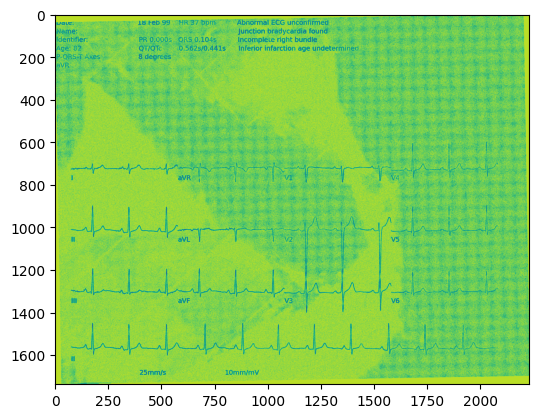

In [11]:
# apply rotation
output_rot = sp.ndimage.rotate(output_im, rot_angle, axes=(1, 0), reshape=True)
plt.figure()
plt.imshow(output_rot)

In [12]:
uint_out = np.uint8(output_im)
uint_out/255

array([[0.98823529, 0.87058824, 0.93333333, ..., 0.88627451, 0.87058824,
        0.87058824],
       [0.87058824, 0.        , 0.88627451, ..., 0.8745098 , 0.97254902,
        0.92941176],
       [0.90980392, 0.75294118, 0.97254902, ..., 0.92156863, 0.95686275,
        0.        ],
       ...,
       [0.85490196, 0.89411765, 0.85882353, ..., 0.        , 0.81568627,
        0.74509804],
       [0.85882353, 0.96078431, 0.85882353, ..., 0.94509804, 0.85490196,
        0.85098039],
       [0.        , 0.85882353, 0.85490196, ..., 0.79607843, 0.84313725,
        0.96470588]])

In [13]:
-uint_out

array([[ 4, 34, 18, ..., 30, 34, 34],
       [34,  0, 30, ..., 33,  8, 19],
       [24, 64,  8, ..., 21, 12,  0],
       ...,
       [38, 28, 37, ...,  0, 48, 66],
       [37, 11, 37, ..., 15, 38, 39],
       [ 0, 37, 38, ..., 53, 41, 10]], dtype=uint8)

In [14]:
-(uint_out/255)

array([[-0.98823529, -0.87058824, -0.93333333, ..., -0.88627451,
        -0.87058824, -0.87058824],
       [-0.87058824, -0.        , -0.88627451, ..., -0.8745098 ,
        -0.97254902, -0.92941176],
       [-0.90980392, -0.75294118, -0.97254902, ..., -0.92156863,
        -0.95686275, -0.        ],
       ...,
       [-0.85490196, -0.89411765, -0.85882353, ..., -0.        ,
        -0.81568627, -0.74509804],
       [-0.85882353, -0.96078431, -0.85882353, ..., -0.94509804,
        -0.85490196, -0.85098039],
       [-0.        , -0.85882353, -0.85490196, ..., -0.79607843,
        -0.84313725, -0.96470588]])

In [15]:
-uint_out/255

array([[0.01568627, 0.13333333, 0.07058824, ..., 0.11764706, 0.13333333,
        0.13333333],
       [0.13333333, 0.        , 0.11764706, ..., 0.12941176, 0.03137255,
        0.0745098 ],
       [0.09411765, 0.25098039, 0.03137255, ..., 0.08235294, 0.04705882,
        0.        ],
       ...,
       [0.14901961, 0.10980392, 0.14509804, ..., 0.        , 0.18823529,
        0.25882353],
       [0.14509804, 0.04313725, 0.14509804, ..., 0.05882353, 0.14901961,
        0.15294118],
       [0.        , 0.14509804, 0.14901961, ..., 0.20784314, 0.16078431,
        0.03921569]])